In [1]:
!pip install -qq einops

In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
import time

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from einops import rearrange

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from PIL import Image

from sklearn.model_selection import train_test_split

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from tqdm.notebook import tqdm
from glob import glob

seed = 42
pd.set_option('display.max_colwidth', None)

In [3]:
def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Currently using "{device.upper()}" device.')

Currently using "CUDA" device.


In [4]:
image_size = 224
drop_rate = 0.2
batch_size = 128

In [5]:
train_transforms = A.Compose([
                      A.OneOf([A.HueSaturationValue(hue_shift_limit=0.2, 
                                                    sat_shift_limit=0.2, 
                                                    val_shift_limit=0.2, 
                                                    p=0.2),      
                      A.RandomBrightnessContrast(brightness_limit=0.2, 
                                                 contrast_limit=0.2, 
                                                 p=0.5)],p=0.2),
                      A.OneOf(
                              [A.HorizontalFlip(p=0.5),
                               A.VerticalFlip(p=0.5),
                               A.RandomRotate90(p=0.5),
                               A.Transpose(p=0.5),
                              ], p=0.5),
                      A.LongestMaxSize(max_size=image_size),
                      A.PadIfNeeded(min_height=image_size, min_width=image_size),
                      # A.Resize(height=image_size, width=image_size, p=1),
                      A.Cutout(num_holes=6, max_h_size=10, max_w_size=10, fill_value=0, p=0.1),
                      A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), max_pixel_value=255.0),
                      ToTensorV2(p=1.0),
                      ], p=1.0)

# only resize, scale [-1, 1] and converting to tensor array[h,w,c] -> tensor[c,h,w]
valid_transforms = A.Compose([
                      A.LongestMaxSize(max_size=image_size),
                      A.PadIfNeeded(min_height=image_size, min_width=image_size),
                      # A.Resize(height=image_size, width=image_size, p=1),
                      A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), max_pixel_value=255.0),
                      ToTensorV2(p=1.0),
                      ], p=1.0)

# inverse trasformations of a single image-tensor
def inverse_transforms(tensor):
    tensor = tensor 
    if tensor.size(0) == 1 and len(tensor.shape) == 4:
        tensor.squeeze_(0)
    tensor = torch.clamp(tensor * 0.5 + 0.5, min=0., max=1.)
    tensor = tensor.cpu().detach().numpy().transpose(1,2,0)

    return tensor

In [6]:
directory = "/kaggle/input/isic-2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input/"

data = pd.read_csv("/kaggle/input/isic-2019/ISIC_2019_Training_GroundTruth.csv").drop("UNK", axis=1)
data["labels"] = data.iloc[:, 1:].idxmax(axis=1)
data = data[~data["image"].str.contains("downsampled")]

classes_to_int = {v: i for i, v in enumerate(data.columns[1:-1])}
int_to_classes = {i: v for i, v in enumerate(data.columns[1:-1])}

data["labels"] = data["labels"].map(classes_to_int)

num_classes = len(classes_to_int)

data.head()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,labels
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [7]:
x_train, x_test = train_test_split(data, test_size=1600, stratify=data["labels"], random_state=seed)
x_valid, x_test = train_test_split(x_test, test_size=400, stratify=x_test["labels"], random_state=seed)

x_train.reset_index(drop=True, inplace=True)
x_valid.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True)

print(f"train size: {len(x_train)}, valid size: {len(x_valid)}, test size: {len(x_test)}")

train size: 21657, valid size: 1200, test size: 400


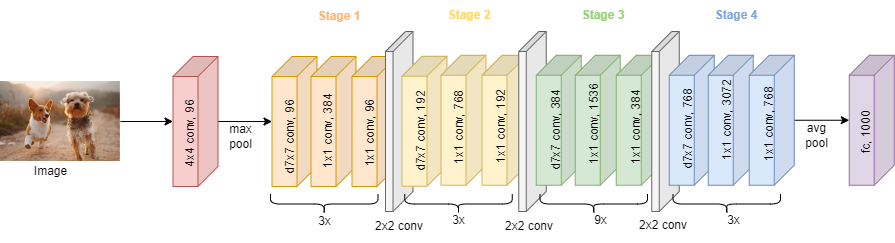

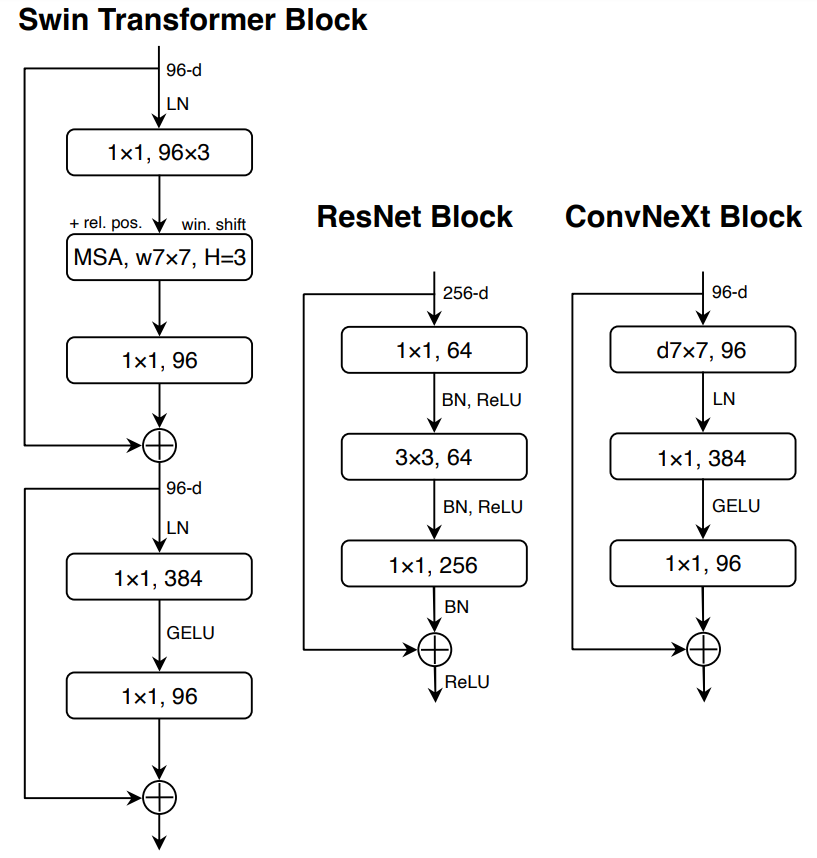

In [8]:
class ResidualBlock(nn.Module):

    def __init__(self, dim, drop_path=0.0, layer_scale=1e-6):
        super(ResidualBlock, self).__init__()
        self.down_conv = nn.Conv2d(dim, dim, kernel_size=7, padding=3, groups=dim)
        self.norm = nn.LayerNorm(dim, eps=1e-6)
        self.pwconv1 = nn.Linear(dim, 4 * dim)
        self.pwconv2 = nn.Linear(4 * dim, dim)
        self.gamma = nn.Parameter(layer_scale * torch.ones((dim)), requires_grad=True) if layer_scale > 0 else None
        self.drop_path = drop_path

    def forward(self, x):
        shortcut = x
        x = self.down_conv(x)
        x = rearrange(x, "b c h w -> b h w c")
        x = self.norm(x)
        x = self.pwconv1(x)
        x = F.gelu(x)
        x = self.pwconv2(x)
        if self.gamma is not None:
            x = self.gamma * x
        x = rearrange(x, "b h w c -> b c h w")

        x = shortcut + self._drop_connections(x)
        return x
    
    def _drop_connections(self, x):
        if not self.training:
            return x
        keep_probability = 1.0 - self.drop_path
        batch_size = x.size(0)
        random_tensor = keep_probability + torch.rand(batch_size, 1, 1, 1, device=x.device)
        binary_tensor = random_tensor.floor()
        return x.div(keep_probability) * binary_tensor

In [9]:
class LayerNorm(nn.LayerNorm):
    def forward(self, x):
        x = rearrange(x, "b c h w -> b h w c")
        x = super().forward(x)
        x = rearrange(x, "b h w c -> b c h w")
        return x

class ConvNeXt(nn.Module):

    def __init__(self, 
                 in_channels=3, 
                 num_classes=10, 
                 depths=[3, 3, 9, 3], 
                 dims=[96, 192, 384, 768], 
                 drop_path=0.0, 
                 layer_scale=1e-6, 
                 head_init_scale=1.0,
                 ):
        super(ConvNeXt, self).__init__()

        self.downsample_layers = nn.ModuleList()
        stem = nn.Sequential(
            nn.Conv2d(in_channels, dims[0], kernel_size=4, stride=4),
            LayerNorm(dims[0], eps=1e-6)
        )
        self.downsample_layers.append(stem)
        for i in range(3):
            downsample_layer = nn.Sequential(
                    LayerNorm(dims[i], eps=1e-6),
                    nn.Conv2d(dims[i], dims[i+1], kernel_size=2, stride=2),
            )
            self.downsample_layers.append(downsample_layer)

        self.stages = nn.ModuleList()
        dp_rates = [x.item() for x in torch.linspace(0, drop_path, sum(depths))] 
        current = 0
        for i in range(4):
            stage = nn.Sequential(
                *[ResidualBlock(dim=dims[i], drop_path=dp_rates[current + j], layer_scale=layer_scale) for j in range(depths[i])]
                )
            self.stages.append(stage)
            current += depths[i]

        self.norm = nn.LayerNorm(dims[-1], eps=1e-6)
        self.head = nn.Linear(dims[-1], num_classes)

        self.apply(self._init_weights)
        self.head.weight.data.mul_(head_init_scale)
        self.head.bias.data.mul_(head_init_scale)

    def _init_weights(self, m):
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            nn.init.trunc_normal_(m.weight, std=0.02)
            nn.init.constant_(m.bias, 0)

    def features(self, x):
        for i in range(4):
            x = self.downsample_layers[i](x)
            x = self.stages[i](x)
        x = x.mean(dim=[2, 3])
        return self.norm(x) 

    def forward(self, x):
        x = self.features(x)
        x = self.head(x)
        return x

In [10]:
class ISICDataset(Dataset):
    def __init__(self, data, transforms):
        self.data = data
        self.transforms = transforms
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, ix):
        row = self.data.loc[ix].squeeze()
        image = Image.open(directory + row["image"] + ".jpg")
        image = np.array(image)
        
        sample = {"image": image}
        image = self.transforms(**sample)["image"]
        
        label = torch.as_tensor(row["labels"], dtype=torch.int64)
        
        return image, label
    
    def collate_fn(self, batch):
        images, labels = list(zip(*batch))
        images, labels = [[tensor[None] for tensor in subset] for subset in (images, labels)]
        images, labels = [torch.cat(subset, dim=0).to(device) for subset in (images, labels)]
        return images, labels

In [11]:
train_ds = ISICDataset(x_train, train_transforms)
valid_ds = ISICDataset(x_valid, valid_transforms)
test_ds = ISICDataset(x_test, valid_transforms)

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=train_ds.collate_fn)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False, collate_fn=valid_ds.collate_fn)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False, collate_fn=test_ds.collate_fn)

In [12]:
def calc_accuracy(y_pred, y_true):
    return (y_true == torch.max(y_pred, 1)[1]).float().mean()

def train_one_batch(data, model, criterion, optimizer):
    model.train()
    images, labels = data
    
    optimizer.zero_grad()
    out = model(images)
    loss = criterion(out, labels)
    
    loss.backward()
    optimizer.step()
    
    accuracy = calc_accuracy(out, labels).item()
    
    return loss.item(), accuracy

@torch.no_grad()
def validate_one_batch(data, model, criterion):
    model.eval()
    images, labels = data
    
    out = model(images)
    loss = criterion(out, labels)
    
    accuracy = calc_accuracy(out, labels)
    
    return loss.item(), accuracy.item()

In [13]:
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0, path='model.pth'):
        self.path = path
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss, model=None, **kwargs):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            checkpoint = {'model': ConvNeXt(**kwargs),
                          'state_dict': model.state_dict(),
                          }
            torch.save(checkpoint, self.path)
            print(f'Model saved to: {self.path}')
            self.best_loss = val_loss
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

In [14]:
params = {"num_classes": num_classes, "drop_path": drop_rate}

model = ConvNeXt(**params).to(device)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5, min_lr=1e-7)
stopper = EarlyStopping(patience=5)

In [15]:
print(f" Number of training parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

 Number of training parameters: 27826280


In [16]:
EPOCHS = 30
print_freq = 20

for epoch in range(1, EPOCHS+1):

    train_loss, train_accs = [], []
    for step, batch in enumerate(train_dl, 1):
        time_1 = time.time()
        
        loss, accuracy = train_one_batch(batch, model, criterion, optimizer)

        train_loss.append(loss)
        train_accs.append(accuracy)
        
        if step % print_freq == 0:
            print('epoch:', epoch, 
                  '\tstep:', step, '/', len(train_dl),
                  '\ttrain loss:', '{:.4f}'.format(loss),
                  '\ttrain accuracy:','{:.4f}'.format(accuracy),
                  '\ttime:', '{:.4f}'.format((time.time()-time_1)*print_freq), 's')
    
    valid_loss, valid_accs = [], []
    for step, batch in enumerate(tqdm(valid_dl)):
        loss, accuracy = validate_one_batch(batch, model, criterion)
        
        valid_loss.append(loss)
        valid_accs.append(accuracy)
        
    print('epoch:', epoch, '/', EPOCHS,
          '\ttrain loss:', '{:.4f}'.format(np.mean(train_loss)),
          '\tvalid loss:', '{:.4f}'.format(np.mean(valid_loss)),
          '\ttrain accuracy', '{:.4f}'.format(np.mean(train_accs)),
          '\tvalid accuracy', '{:.4f}'.format(np.mean(valid_accs)))
        
    stopper(np.mean(valid_loss), model, **params)
    scheduler.step(np.mean(valid_loss))
    
test_loss, test_accs = [], []
for step, batch in enumerate(tqdm(test_dl)):
    loss, accuracy = validate_one_batch(batch, model, criterion)

    test_loss.append(loss)
    test_accs.append(accuracy)

print('\ttest loss:', '{:.4f}'.format(np.mean(test_loss)),
      '\ttest accuracy', '{:.4f}'.format(np.mean(test_accs)))

epoch: 1 	step: 20 / 170 	train loss: 1.6069 	train accuracy: 0.5156 	time: 62.0254 s
epoch: 1 	step: 40 / 170 	train loss: 1.4233 	train accuracy: 0.5547 	time: 62.1952 s
epoch: 1 	step: 60 / 170 	train loss: 1.4562 	train accuracy: 0.4922 	time: 62.2256 s
epoch: 1 	step: 80 / 170 	train loss: 1.4427 	train accuracy: 0.4531 	time: 62.0592 s
epoch: 1 	step: 100 / 170 	train loss: 1.3640 	train accuracy: 0.4609 	time: 62.4216 s
epoch: 1 	step: 120 / 170 	train loss: 1.2961 	train accuracy: 0.5625 	time: 62.2169 s
epoch: 1 	step: 140 / 170 	train loss: 1.2655 	train accuracy: 0.5703 	time: 62.1167 s
epoch: 1 	step: 160 / 170 	train loss: 1.2802 	train accuracy: 0.5469 	time: 62.2034 s


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 1 / 40 	train loss: 1.4736 	valid loss: 1.2931 	train accuracy 0.5004 	valid accuracy 0.5534


  0%|          | 0/4 [00:00<?, ?it/s]

	test loss: 1.3020 	test accuracy 0.5273


In [ ]:
def load_checkpoint(filepath="model.pth", device="cuda"):
    checkpoint = torch.load(filepath, map_location=device)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False

    model.eval()
    return model

model = load_checkpoint()

In [17]:
@torch.no_grad()
def plot(num_images, model):
    model.eval()
    indices = np.random.choice(np.arange(len(test_ds)), size=num_images)
    num_cols = 3
    num_rows = int(np.ceil(num_images / num_cols))
    
    plt.figure(figsize=(num_rows * 3, num_cols*3))
    for j, i in enumerate(indices, 1):
        image, label = test_ds[i]
        out = model(image.unsqueeze(0).to(device))
        y_pred = int_to_classes.get(torch.max(out, 1)[1][0].item(), "error")
        label = int_to_classes.get(label.item(), "error")
        
        image = inverse_transforms(image)
        plt.subplot(num_rows, num_cols, j)
        plt.imshow(image)
        plt.title(f"True label: {label}, pred: {y_pred}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

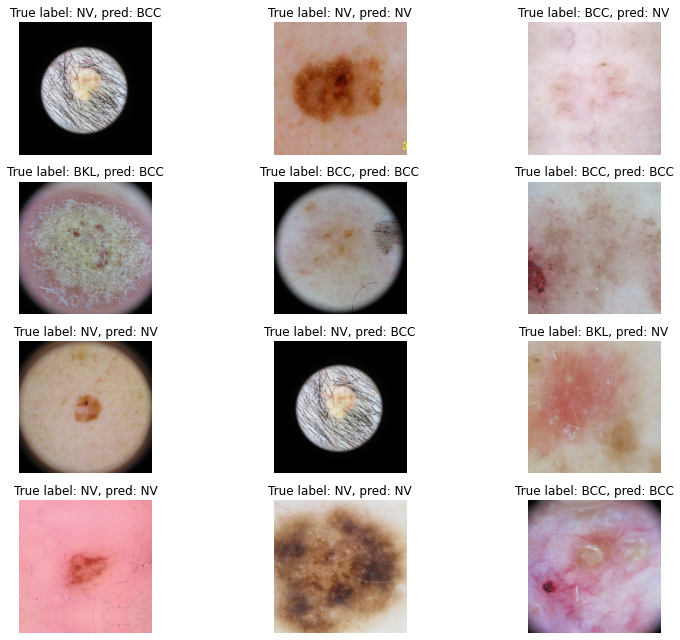

In [18]:
plot(num_images=12, model=model)

# [See results](https://www.kaggle.com/code/pankratozzi/pytorch-convnext-implementation)